In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
#%pylab inline

In [2]:

from gensim.corpora import Dictionary
from gensim.models import  LsiModel, LdaModel, TfidfModel


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:02, 3208.66it/s]


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [6]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [7]:
df=pd.DataFrame.from_dict(responses)

In [8]:
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
author                153479 non-null object
bank_license          153498 non-null object
bank_name             153499 non-null object
city                  138325 non-null object
datetime              153499 non-null object
num_comments          153499 non-null int64
rating_grade          88658 non-null float64
rating_not_checked    153499 non-null bool
text                  153499 non-null object
title                 153499 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [10]:
# Удалим те наблюдения где рейтинг неизвестен
df.dropna(subset=['rating_grade'], inplace = True)

In [11]:
df.shape

(88658, 10)

### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [12]:
cities=df.groupby(['city']).count()['text'].sort_values( ascending=False).head(29)
banks=df.groupby(['bank_name']).count()['text'].sort_values( ascending=False).head(29)

Text(0.5, 0, 'Количество отзывов')

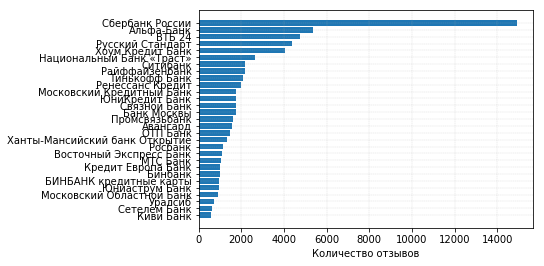

In [13]:
plt.barh(banks.index[::-1],banks.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов')

Text(0.5, 0, 'Количество отзывов')

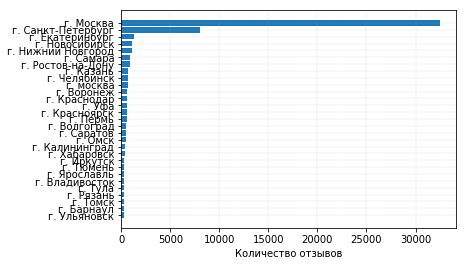

In [14]:
plt.barh(cities.index[::-1],cities.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов')

### 2. Постройте гистограмы длин слов в символах и в словах

In [15]:
#длина в символах
len_chars = df.text.apply(len)
len_chars.describe()

count    88658.000000
mean      1718.655711
std       1387.903005
min         31.000000
25%        852.000000
50%       1345.000000
75%       2131.000000
max      32082.000000
Name: text, dtype: float64

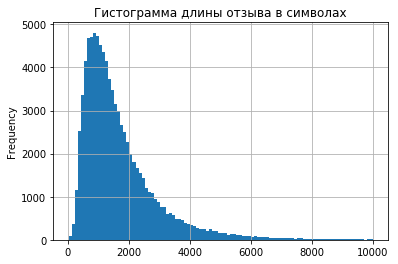

In [16]:
len_chars[len_chars<10000].plot(kind='hist',bins=100, title='Гистограмма длины отзыва в символах')

plt.grid(True)


In [17]:
len_tokens = df.text.str.split().apply(len)
len_tokens.describe()

count    88658.00000
mean       262.54814
std        213.16522
min          5.00000
25%        129.00000
50%        205.00000
75%        326.00000
max       5000.00000
Name: text, dtype: float64

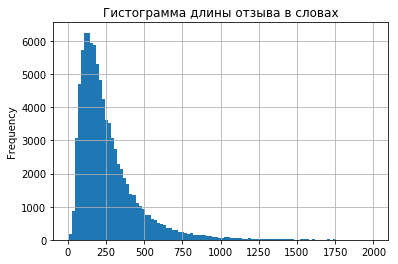

In [18]:
len_tokens[len_tokens<2000].plot(kind='hist',bins=100, title='Гистограмма длины отзыва в словах')
plt.grid(True)

### Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм

#### Cлова

In [19]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""




In [20]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [21]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('в', 859205)
('и', 683760)
('не', 541870)
('на', 453390)
('что', 417356)
('я', 368386)
('с', 288214)
('по', 232882)
('мне', 209093)
('банка', 171118)


#### Cлова без стоп-слов

In [22]:
from nltk.corpus import stopwords
 #print(stopwords.words('russian'))
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return 

In [23]:
df['text_tokinized_without_stop_worlds'] =  df.text_tokinized.str.lower().apply(remove_stopwords)
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,text_tokinized,text_tokinized_without_stop_worlds
14,yura1189,лицензия № 2673,Тинькофф Банк,г. Москва,2015-06-05 13:52:40,0,2.0,False,"Также как и многие давний клиент банка, был до...",В Шоке,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...
19,agelun,лицензия № 1481,Сбербанк России,г. Москва,2015-06-05 15:00:54,2,1.0,False,Открыт вклад и счет в USD. Плюс к этому есть з...,Некомпетентность сотрудников банка,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...
33,Joker888,лицензия № 1481,Сбербанк России,г. Ростов-на-Дону,2015-06-05 21:35:40,1,1.0,False,Доброго времени! Вчера мне поступило смс-уведо...,Навязывание страховки,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...


In [24]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_without_stop_worlds'].split()
    tokens_all+=tokens
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('банка', 171118)
('банк', 130753)
('деньги', 83171)
('карту', 69033)
('карты', 63121)
('отделение', 48431)
('день', 48092)
('кредит', 47746)
('банке', 46245)
('заявление', 45279)


In [25]:
#### Ну, видно , что нужна лемматизация, в десятке - 3 разных формы банка

#### Леммы

In [26]:
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
   

In [27]:
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [28]:


df['lemma'] = df['text_tokinized_without_stop_worlds'].apply(lemmatize)

df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,text_tokinized,text_tokinized_without_stop_worlds,lemma
14,yura1189,лицензия № 2673,Тинькофф Банк,г. Москва,2015-06-05 13:52:40,0,2.0,False,"Также как и многие давний клиент банка, был до...",В Шоке,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...
19,agelun,лицензия № 1481,Сбербанк России,г. Москва,2015-06-05 15:00:54,2,1.0,False,Открыт вклад и счет в USD. Плюс к этому есть з...,Некомпетентность сотрудников банка,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,открывать вклад счет плюс этот зарплатный карт...
33,Joker888,лицензия № 1481,Сбербанк России,г. Ростов-на-Дону,2015-06-05 21:35:40,1,1.0,False,Доброго времени! Вчера мне поступило смс-уведо...,Навязывание страховки,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...,добрый время вчера поступать смс уведомление б...


In [29]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens.append(sum(cnt.values()))
    #break
for i in cnt.most_common(10):
    print(i)


('банк', 384996)
('карта', 211438)
('деньги', 114344)
('день', 112771)
('отделение', 105610)
('мой', 98205)
('который', 94316)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)


#### Еще раз причешем наши леммы, за одно попробуем мульпроцессинг

In [30]:
%%time
from multiprocessing import Pool
with Pool(8) as p:
    df['lemma']=p.map(remove_stoplemmas,df.lemma)

CPU times: user 948 ms, sys: 524 ms, total: 1.47 s
Wall time: 3.65 s


In [31]:
len(tokens_all)

14041820

In [32]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens.append(sum(cnt.values()))
    #break
for i in cnt.most_common(10):
    print(i)


('банк', 384996)
('карта', 211438)
('деньги', 114344)
('день', 112771)
('отделение', 105610)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)
('счет', 81909)
('сказать', 77633)


In [33]:
# чуть-чуть уменьшилось у нас разнообразие, видимо полезная операция
len(tokens_all)/14041820

0.9493268678846475

### Существительные

In [34]:
def to_nouns(text, mystem=m):
    
    m=MorphAnalyzer()
    try:
        
        return  " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []
to_nouns(df.lemma.iloc[1])

'вклад счет карта рубль отделение цель операционист паспорт карта окошко карта подтверждение операция деньги счет операционист вс карта терминал пин вв л пин ответ чек доллар карта рубль вопрос банка операция угол квартал курс валюта рубль операция шаг рубль рубль карта банкомат час выяснение отношение операционист начальник попытка транзакция п разница зачисление доллар рубл карта руб доллар слово операционист курс покупка валюта руб доллар доллар чек курс транзакция доллар рубл выя печать доллар час курс тадааам комиссия банк операционист комиссия курсы проведение операция вывод итог час время нерв фига рубль вывод клиент распечатка операция операционист проведение подтверждение операция ом плата вопрос банка сбер работа сотрудник'

In [35]:
%%time
from multiprocessing import Pool
with Pool() as p:
    df['nouns']=p.map(to_nouns,df.lemma)

CPU times: user 2.02 s, sys: 1.13 s, total: 3.15 s
Wall time: 19min 40s


In [36]:
df.iloc[:3,-5:]

,title,text_tokinized,text_tokinized_without_stop_worlds,lemma,nouns
14,В Шоке,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...,клиент банк степень друг большинство сотрудник...
19,Некомпетентность сотрудников банка,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,открывать вклад счет плюс зарплатный карта руб...,вклад счет карта рубль отделение цель операцио...
33,Навязывание страховки,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...,добрый время вчера поступать смс уведомление б...,время смс уведомление банк предложение кредит ...


In [37]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['nouns'].split()
    #print(tokens)
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens_noun.append(sum(cnt.values()))
    #break
for i in cnt_noun.most_common(10):
    print(i)


('банк', 384996)
('карта', 211438)
('деньги', 114344)
('день', 112771)
('отделение', 105610)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)
('счет', 81909)
('заявление', 66721)


#### 4. Постройте кривые Ципфа и Хипса

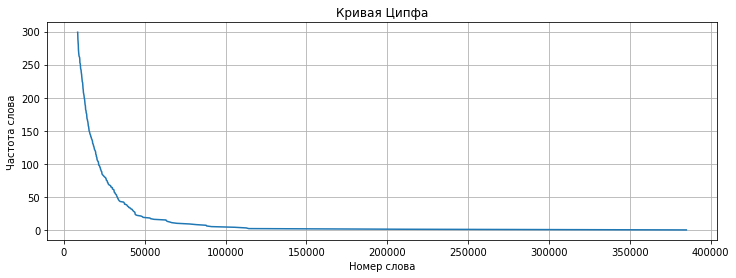

In [38]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.grid()

plt.show()

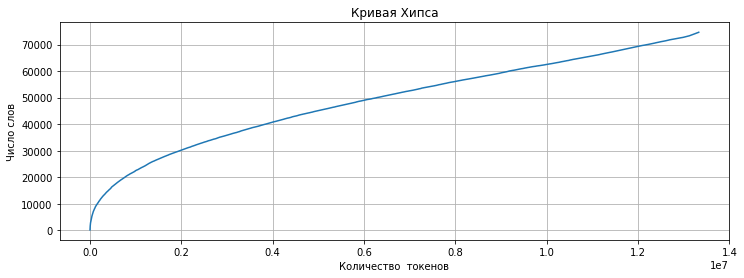

In [39]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens,n_types)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.grid()

plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [40]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)


In [41]:
print('Слово "сотрудник" встрчается -"',Freq_Dist['сотрудник'],'раз')
print('Слово "клиент" встрчается -"',Freq_Dist['клиент'],'раз')
print(Freq_Dist['сотрудник'] >Freq_Dist['клиент'])


Слово "сотрудник" встрчается -" 88252 раз
Слово "клиент" встрчается -" 88018 раз
True


In [42]:
print('Слово "мошенничество" встрчается -"',Freq_Dist['мошенничество'],'раз')
print('Слово "доверие" встрчается -"',Freq_Dist['доверие'],'раз')

Слово "мошенничество" встрчается -" 1299 раз
Слово "доверие" встрчается -" 1259 раз


#### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [43]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [44]:
### У нас оч сбалансированная выборка, как видим.  Выберем например , по  7тысяч примеров

In [45]:
num=7000
df_for_tf_idf = df[(df.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(df[(df.rating_grade==5)].sample(n=num))

In [46]:
df_for_tf_idf.rating_grade.value_counts()

5.0    7000
1.0    7000
Name: rating_grade, dtype: int64

In [47]:
tokens_by_topic = []

In [48]:
for rating in df_for_tf_idf.rating_grade.unique():
    print(rating)
    #if df['topic'].value_counts()[topic] > 100: 
    tokens=[]
    sample=df_for_tf_idf[df_for_tf_idf['rating_grade']==rating]
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
    tokens_by_topic.append(tokens)

1.0
5.0


#### Униграммы

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)    

#### На уровне юниграмм , кстати, многое пересекается. Видно однако некоторые особенности.

In [50]:

rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(15)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,банк,банк
1,карта,карта
2,очень,деньги
3,кредит,день
4,день,отделение
5,клиент,кредит
6,отделение,сотрудник
7,сотрудник,счет
8,деньги,клиент
9,вклад,сказать


In [51]:
rankings.shape

(70, 2)

#### Попробуем исключить пресекающщиейся леммы из топов

In [52]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]

In [53]:
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [54]:
#Ну таки вот так больше разницу видно
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
17,обслуживание,ответ
29,интернет,сбербанк
31,открывать,ваш
34,банка,отвечать
37,первый,рубль
39,хороший,средство
44,процент,ситуация
48,несколько,информация
57,условие,неделя
60,предлагать,оператор


#### Проделаем такое же упражнении для биграмм

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [56]:
### Ну та же самая картинка. Много пересекается. Проделаем тот же трюк
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(15)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,интернет банк,сотрудник банк
1,кредитный карта,написать заявление
2,сотрудник банк,кредитный карта
3,клиент банк,отделение банк
4,следующий день,денежный средство
5,открывать вклад,горячий линия
6,отделение банк,рабочий день
7,являться клиент,колл центр
8,дебетовый карта,интернет банк
9,добрый день,служба поддержка


In [57]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]

In [58]:
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [59]:
#Весьма показательно, кстати, получилось
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
17,очень довольный,кредитный история
18,приятно удивлять,получать ответ
19,работа банк,кредитный договор
21,банк очень,деньги счет
23,пользоваться услуга,писать заявление
25,очень удобно,отделение сбербанк
34,огромный спасибо,деньги карта
35,большой спасибо,звонить банк
37,очень удобный,срок рассмотрение
38,банк год,допы офис


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [60]:
from gensim.corpora import *
texts = [df.lemma.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [61]:

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [62]:
%time lsi_5 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

CPU times: user 1min 59s, sys: 27.4 s, total: 2min 26s
Wall time: 52.7 s


In [63]:
lsi_5.show_topics(5)

[(0,
  '0.196*"карта" + 0.131*"кредит" + 0.112*"заявление" + 0.111*"деньги" + 0.111*"вклад" + 0.106*"банкомат" + 0.106*"счет" + 0.099*"отделение" + 0.092*"сумма" + 0.091*"сбербанк"'),
 (1,
  '-0.576*"вклад" + 0.176*"кредит" + -0.175*"открывать" + -0.170*"очередь" + 0.135*"платеж" + 0.134*"заявление" + 0.127*"задолженность" + 0.114*"погашение" + -0.095*"минута" + -0.095*"офис"'),
 (2,
  '0.378*"кредит" + -0.351*"банкомат" + -0.274*"карта" + 0.242*"страховка" + 0.170*"договор" + -0.163*"сбербанк" + 0.138*"страхование" + -0.137*"деньги" + 0.132*"погашение" + -0.129*"операция"'),
 (3,
  '0.350*"вклад" + -0.257*"заявка" + -0.224*"карта" + 0.188*"сумма" + 0.186*"банкомат" + 0.150*"платеж" + 0.149*"погашение" + 0.140*"средство" + 0.138*"руб" + 0.135*"деньги"'),
 (4,
  '-0.469*"банкомат" + -0.305*"страховка" + 0.231*"карта" + 0.183*"задолженность" + -0.177*"страхование" + 0.150*"вклад" + -0.134*"купюра" + -0.119*"деньги" + -0.117*"заявка" + -0.116*"кредит"')]

In [64]:
lsi_10 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [65]:
lsi_10.show_topics(10)

[(0,
  '0.196*"карта" + 0.131*"кредит" + 0.111*"заявление" + 0.111*"деньги" + 0.110*"вклад" + 0.107*"банкомат" + 0.106*"счет" + 0.099*"отделение" + 0.092*"сумма" + 0.090*"сбербанк"'),
 (1,
  '-0.589*"вклад" + -0.178*"открывать" + -0.168*"очередь" + 0.159*"кредит" + 0.133*"заявление" + 0.130*"платеж" + 0.122*"задолженность" + 0.107*"погашение" + -0.095*"депозит" + -0.094*"офис"'),
 (2,
  '-0.385*"банкомат" + 0.377*"кредит" + -0.263*"карта" + 0.210*"страховка" + 0.165*"договор" + -0.148*"сбербанк" + -0.148*"деньги" + 0.140*"погашение" + -0.128*"операция" + 0.128*"документ"'),
 (3,
  '0.324*"вклад" + -0.280*"карта" + -0.242*"заявка" + 0.228*"банкомат" + 0.186*"сумма" + 0.146*"деньги" + 0.144*"погашение" + 0.143*"платеж" + 0.131*"средство" + 0.130*"руб"'),
 (4,
  '-0.382*"банкомат" + 0.339*"карта" + 0.222*"вклад" + -0.139*"очередь" + -0.139*"заявка" + -0.134*"кредит" + 0.128*"задолженность" + -0.124*"купюра" + -0.116*"терминал" + 0.115*"счет"'),
 (5,
  '0.309*"вклад" + 0.193*"заявка" + 0.1

In [66]:
lsi_20 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)

In [67]:
lsi_20.show_topics()

[(0,
  '0.196*"карта" + 0.131*"кредит" + 0.111*"заявление" + 0.111*"деньги" + 0.110*"вклад" + 0.107*"банкомат" + 0.106*"счет" + 0.099*"отделение" + 0.092*"сумма" + 0.090*"сбербанк"'),
 (1,
  '-0.590*"вклад" + -0.178*"открывать" + -0.167*"очередь" + 0.156*"кредит" + 0.135*"заявление" + 0.131*"платеж" + 0.120*"задолженность" + 0.106*"погашение" + -0.094*"офис" + -0.094*"минута"'),
 (2,
  '-0.388*"банкомат" + 0.376*"кредит" + -0.259*"карта" + 0.209*"страховка" + 0.169*"договор" + -0.150*"деньги" + -0.148*"сбербанк" + 0.139*"погашение" + -0.128*"операция" + 0.128*"документ"'),
 (3,
  '0.325*"вклад" + -0.293*"карта" + 0.239*"банкомат" + -0.236*"заявка" + 0.186*"сумма" + 0.148*"деньги" + 0.146*"платеж" + 0.144*"погашение" + 0.131*"руб" + 0.126*"средство"'),
 (4,
  '-0.406*"банкомат" + 0.334*"карта" + 0.244*"вклад" + -0.142*"заявка" + -0.137*"кредит" + -0.132*"очередь" + 0.125*"задолженность" + -0.121*"купюра" + 0.118*"счет" + 0.111*"закрывать"'),
 (5,
  '0.300*"вклад" + 0.214*"сбербанк" + 0.

In [68]:
from gensim.models.ldamulticore import LdaMulticore


In [69]:

%time ldamodel_5 = LdaMulticore(corpus, num_topics=5, id2word = dictionary, passes=20,workers =5)

CPU times: user 4min 26s, sys: 17 s, total: 4min 43s
Wall time: 4min 17s


In [70]:
ldamodel_5.show_topics()

[(0,
  '0.041*"банк" + 0.014*"счет" + 0.013*"заявление" + 0.013*"сотрудник" + 0.010*"г" + 0.010*"данный" + 0.009*"средство" + 0.009*"ответ" + 0.009*"день" + 0.008*"клиент"'),
 (1,
  '0.034*"банк" + 0.016*"вклад" + 0.014*"клиент" + 0.009*"отделение" + 0.009*"очень" + 0.009*"очередь" + 0.008*"офис" + 0.007*"время" + 0.007*"работать" + 0.007*"открывать"'),
 (2,
  '0.063*"карта" + 0.024*"банк" + 0.018*"деньги" + 0.016*"банкомат" + 0.011*"счет" + 0.009*"день" + 0.008*"отделение" + 0.007*"заявление" + 0.007*"получать" + 0.006*"проблема"'),
 (3,
  '0.048*"кредит" + 0.035*"банк" + 0.016*"сумма" + 0.015*"кредитный" + 0.013*"платеж" + 0.012*"договор" + 0.011*"документ" + 0.010*"день" + 0.009*"год" + 0.009*"месяц"'),
 (4,
  '0.015*"банк" + 0.014*"сказать" + 0.012*"день" + 0.012*"звонить" + 0.010*"деньги" + 0.010*"отделение" + 0.010*"говорить" + 0.009*"позвонить" + 0.008*"девушка" + 0.008*"приходить"')]

In [71]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel_5, corpus, dictionary)
pyLDAvis.display(vis)

/home/gavril/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


####  Вот тут видно, например:
     - Хорошо отделась тьема №5 - "0.048*"кредит" + 0.035*"банк" + 0.016*"сумма" + 0.015*"кредитный" + 0.013*"платеж" + 0.012*"договор" + 0.011*"документ" + 0.010*"день" + 0.009*"год" + 0.009*"месяц"')," Здесб речь идет о кредитах и все, чтио с нимим связанл - как, где погашать, какие проценты
     - Или такая тема -"'0.034*"банк" + 0.016*"вклад" + 0.014*"клиент" + 0.009*"отделение" + 0.009*"очень" + 0.009*"очередь" + 0.008*"офис" + 0.007*"время" + 0.007*"работать" + 0.007*"открывать"')," -речь идет о работе офисов


In [72]:
ldamodel_10 = LdaMulticore(corpus, num_topics=10, id2word = dictionary, passes=20,workers =5)
ldamodel_10.show_topics(10)

[(0,
  '0.043*"банк" + 0.017*"клиент" + 0.014*"сотрудник" + 0.013*"данный" + 0.011*"ответ" + 0.009*"ваш" + 0.009*"информация" + 0.008*"вопрос" + 0.007*"получать" + 0.007*"обращение"'),
 (1,
  '0.032*"счет" + 0.030*"банк" + 0.027*"сумма" + 0.025*"карта" + 0.022*"комиссия" + 0.021*"рубль" + 0.014*"деньги" + 0.014*"руб" + 0.012*"операция" + 0.012*"средство"'),
 (2,
  '0.019*"банк" + 0.014*"отделение" + 0.013*"очередь" + 0.013*"клиент" + 0.010*"работать" + 0.009*"офис" + 0.009*"минута" + 0.009*"человек" + 0.008*"вклад" + 0.008*"время"'),
 (3,
  '0.064*"кредит" + 0.029*"банк" + 0.019*"договор" + 0.015*"сумма" + 0.012*"кредитный" + 0.011*"страховка" + 0.011*"оформлять" + 0.010*"документ" + 0.008*"погашение" + 0.008*"год"'),
 (4,
  '0.051*"деньги" + 0.038*"банкомат" + 0.018*"сбербанк" + 0.017*"день" + 0.014*"банк" + 0.013*"заявление" + 0.012*"счет" + 0.011*"карта" + 0.010*"отделение" + 0.009*"операция"'),
 (5,
  '0.024*"день" + 0.023*"банк" + 0.018*"заявка" + 0.014*"позвонить" + 0.014*"сказат

In [73]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(ldamodel_10, corpus, dictionary)
pyLDAvis.display(vis_data)

####  
    -0.036*"банк" + 0.024*"кредит" + 0.018*"платеж" + 0.012*"задолженность" + 0.011*"звонить" + 0.010*"кредитный" + 0.010*"сумма" + 0.009*"звонок" + 0.009*"день" + 0.009*"месяц"'), -тоже что о о креджитах
    -'0.032*"счет" + 0.030*"банк" + 0.027*"сумма" + 0.025*"карта" + 0.022*"комиссия" + 0.021*"рубль" + 0.014*"деньги" + 0.014*"руб" + 0.012*"операция" + 0.012*"средство"'), - какие-то вопросы об операциях
    - '0.043*"банк" + 0.033*"вклад" + 0.025*"счет" + 0.023*"г" + 0.021*"отделение" + 0.018*"заявление" + 0.016*"деньги" + 0.014*"договор" + 0.014*"день" + 0.014*"офис"') -о вкладах узнают клиенты

In [74]:
from gensim.models.ldamulticore import LdaMulticore
ldamodel_20 = LdaMulticore(corpus, num_topics=20, id2word = dictionary, passes=20,workers =5)
ldamodel_20.show_topics(20)

[(0,
  '0.029*"банк" + 0.017*"интернет" + 0.016*"услуга" + 0.014*"смс" + 0.014*"поддержка" + 0.013*"проблема" + 0.012*"система" + 0.011*"оператор" + 0.011*"номер" + 0.011*"телефон"'),
 (1,
  '0.086*"кредит" + 0.035*"банк" + 0.019*"страховка" + 0.019*"договор" + 0.016*"оформлять" + 0.015*"сумма" + 0.013*"кредитный" + 0.010*"страхование" + 0.010*"условие" + 0.009*"сказать"'),
 (2,
  '0.200*"карта" + 0.022*"отделение" + 0.019*"получать" + 0.019*"кредитный" + 0.016*"банк" + 0.010*"сотрудник" + 0.010*"оформлять" + 0.010*"обслуживание" + 0.009*"выпускать" + 0.009*"офис"'),
 (3,
  '0.052*"документ" + 0.025*"банк" + 0.023*"справка" + 0.015*"квартира" + 0.014*"сделка" + 0.013*"кредит" + 0.012*"ипотека" + 0.010*"ипотечный" + 0.010*"день" + 0.009*"менеджер"'),
 (4,
  '0.100*"вс" + 0.063*"ещ" + 0.050*"сч" + 0.038*"м" + 0.037*"л" + 0.023*"е" + 0.016*"мо" + 0.014*"деньги" + 0.014*"плата" + 0.013*"ч"'),
 (5,
  '0.041*"кредит" + 0.036*"банк" + 0.032*"платеж" + 0.030*"сумма" + 0.019*"задолженность" + 0

In [75]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(ldamodel_20, corpus, dictionary)
pyLDAvis.display(vis_data)

#### Здесь также понято содержание многих тем(хотя видимо 20 тем это много- некоторые сильно персекаются)
  - '0.056*"выписка" + 0.049*"счет" + 0.040*"письмо" + 0.036*"почта" + 0.027*"отправлять" + 0.017*"электронный" + 0.015*"мтс" + 0.015*"ответ" + 0.014*"получать" + 0.014*"платеж"')- о работе и нтреснет-банка
  -  '0.038*"заявление" + 0.032*"банк" + 0.029*"день" + 0.019*"ответ" + 0.018*"претензия" + 0.017*"отделение" + 0.016*"написать" + 0.015*"сотрудник" + 0.014*"срок" + 0.012*"обращаться"') -какие-т о жалобы на обслуживание
  - '0.200*"карта" + 0.022*"отделение" + 0.019*"получать" + 0.019*"кредитный" + 0.016*"банк" + 0.010*"сотрудник" + 0.010*"оформлять" + 0.010*"обслуживание" + 0.009*"выпускать" + 0.009*"офис"')- что-то об офрмление кредитных карт
  -  '0.052*"документ" + 0.025*"банк" + 0.023*"справка" + 0.015*"квартира" + 0.014*"сделка" + 0.013*"кредит" + 0.012*"ипотека" + 0.010*"ипотечный" + 0.010*"день" + 0.009*"менеджер"') - что-то об ипотеке людей инресует

In [76]:
print('helow')

helow


#### 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

#### Из всех банков в  выборке в тематики попали только Сбер и Альфа. Что немудрено- их больше всего в датасете:

In [254]:
df.bank_name.value_counts(normalize=1).head()

Сбербанк России     0.168558
Альфа-Банк          0.060660
ВТБ 24              0.053870
Русский Стандарт    0.049268
Хоум Кредит Банк    0.045433
Name: bank_name, dtype: float64

#### Вот что LSI выделила:

#####  Сбер
    
   - '0.309*"вклад" + 0.193*"заявка" + 0.190*"заявление" + 0.169*"сбербанк" + 0.160*"рассмотрение" + -0.143*"комиссия" + -0.132*"платеж" + -0.127*"карта" + 0.125*"срок" + 0.124*"обращение" - вот она бюрократия зеленого банка

   - '0.356*"страховка" + 0.302*"банкомат" + 0.233*"карта" + -0.222*"платеж" + 0.188*"страхование" + 0.171*"заявка" + -0.147*"номер" + -0.139*"перевод" + 0.125*"вклад" + -0.123*"сбербанк"' - видимо есть какие-то проблемы со страховкой
 


##### Альфа
 - 0.442*"альфа" + -0.211*"услуга" + -0.208*"претензия" + -0.198*"смс" + -0.180*"подключать" + 0.179*"платеж" + -0.171*"закрывать" + -0.154*"справка" + -0.146*"закрытие" + 0.142*"кошелек"' -какая-то операционная тематика, сложно сказать что-то
 - 0.392*"горячий" + -0.389*"линия" + -0.341*"справка" + 0.184*"карточка" + -0.173*"терминал" + -0.170*"комиссия" + 0.167*"платеж" + -0.166*"руб" + 0.141*"альфа" + -0.132*"связной" - вот это вот любопытно,  очевидно речь идет о какой-то услуге которую свзяной оказывает(термина, связной, коммисия) я б тут покапался
 - 0.344*"сбербанк" + 0.199*"заявление" + 0.198*"подключать" + -0.194*"альфа" + 0.189*"услуга" + 0.188*"смс" + 0.181*"досрочный" + 0.179*"справка" + 0.173*"погашение" + -0.169*"претензия"' - здесь интресно что и сбер и альфа фигурирует видимо у обоих были проблемы с интернет банком

#### Вот что LDA  выделила:

#####  Сбер


 - '0.051*"деньги" + 0.038*"банкомат" + 0.018*"сбербанк" + 0.017*"день" + 0.014*"банк" + 0.013*"заявление" + 0.012*"счет" + 0.011*"карта" + 0.010*"отделение" + 0.009*"операция"' - тут также сложно скзазать, видимо речь идет о проблемах с картами
 - '0.103*"сбербанк" + 0.033*"отделение" + 0.025*"деньги" + 0.023*"г" + 0.020*"платеж" + 0.014*"счет" + 0.012*"оплачивать" + 0.011*"сбер" + 0.010*"терминал" + 0.010*"оплата"'- видимо о какахто платежах через терминалы итдет речь

####  Можно отметить что есть куда  расти с точки зрение проолбработки Сбербанк-Сбер, страхование-страховка и.т.д
В целом неплохо структировались проблемы. Мне показалcz любоптытным кейс с альфой связным

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

### 1) Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение).
Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.1) 

#### Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [77]:
df.head(2)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,text_tokinized,text_tokinized_without_stop_worlds,lemma,nouns
14,yura1189,лицензия № 2673,Тинькофф Банк,г. Москва,2015-06-05 13:52:40,0,2.0,False,"Также как и многие давний клиент банка, был до...",В Шоке,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...,клиент банк степень друг большинство сотрудник...
19,agelun,лицензия № 1481,Сбербанк России,г. Москва,2015-06-05 15:00:54,2,1.0,False,Открыт вклад и счет в USD. Плюс к этому есть з...,Некомпетентность сотрудников банка,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,открывать вклад счет плюс зарплатный карта руб...,вклад счет карта рубль отделение цель операцио...


In [78]:
num=4000
df_for_tf_idf = df[(df.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(df[(df.rating_grade==5)].sample(n=num))

df_for_tf_idf.rating_grade.value_counts()

5.0    4000
1.0    4000
Name: rating_grade, dtype: int64

In [79]:
# Ну мы уже выбирали по 7 тыс возьмем их
df_for_tf_idf.rating_grade.value_counts()

5.0    4000
1.0    4000
Name: rating_grade, dtype: int64

In [80]:
X=df_for_tf_idf.lemma.values
y=df_for_tf_idf.rating_grade.values

In [81]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,stratify=y)

In [82]:
import collections, numpy
collections.Counter(y_test)

Counter({5.0: 1200, 1.0: 1200})

#### 2) Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baselin. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам.

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
clf_countvectorized = Pipeline([
    
    
    ('vect', CountVectorizer()),
   
   ('clf', LogisticRegression()),
])


In [84]:

params_cntv={
    'vect__analyzer':  ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]

  
}
scores=[ 'accuracy','f1']
grid_cntv = GridSearchCV(clf_countvectorized, param_grid=params_cntv, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_cntv.fit(X_train, y_train)
print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed: 11.2min finished
/home/gavril/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])
Best score: 0.931


Precision:   0.94
Recall:   0.94
F1-measure:   0.94
Accuracy:   0.94
              precision    recall  f1-score   support

         1.0       0.94      0.93      0.94      1200
         5.0       0.93      0.94      0.94      1200

   micro avg       0.94      0.94      0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



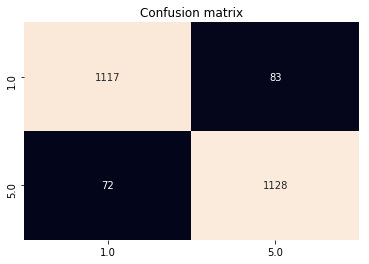

In [90]:
from sklearn.metrics import *
import seaborn as sns
predictions=grid_cntv.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))



labels = grid_cntv.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:

Count_vectorized_model=pd.DataFrame.from_dict(grid_cntv.cv_results_)

In [93]:
print(grid_cntv.best_estimator_)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


#### Грид на выбрал как лучший униграммы по словам

In [224]:
Count_vectorized_model[['param_clf__C','param_clf__penalty','param_vect__analyzer','param_vect__max_df','param_vect__ngram_range','mean_test_accuracy','mean_test_f1']].sort_values('mean_test_accuracy', ascending=False).head(15)

,param_clf__C,param_clf__penalty,param_vect__analyzer,param_vect__max_df,param_vect__ngram_range,mean_test_accuracy,mean_test_f1
96,0.1,l2,word,1,"(1, 1)",0.931250,0.931454
90,0.1,l2,word,0.5,"(1, 1)",0.930893,0.931120
93,0.1,l2,word,0.75,"(1, 1)",0.930714,0.930928
126,1,l2,word,0.5,"(1, 1)",0.927857,0.927913
129,1,l2,word,0.75,"(1, 1)",0.927857,0.927914
132,1,l2,word,1,"(1, 1)",0.926964,0.926909
60,0.01,l2,word,1,"(1, 1)",0.923036,0.923090
57,0.01,l2,word,0.75,"(1, 1)",0.922500,0.922516
54,0.01,l2,word,0.5,"(1, 1)",0.922500,0.922545
168,10,l2,word,1,"(1, 1)",0.921607,0.921538


### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
      1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
      2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

#### 1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

In [96]:

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

#### Попробуем только 𝑡𝑓−𝑖𝑑𝑓  

In [165]:

clf_tf_idf = Pipeline([
    
    
   ('vect', CountVectorizer()),
 
       ('tfidf', TfidfTransformer()),
   
   ('clf', LogisticRegression()),
])


In [169]:


params_tf_idf={
    
    'vect__analyzer':  ['word','char'],
    
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]

  
}
scores=[ 'accuracy','f1']
grid_tf_idf = GridSearchCV(clf_tf_idf, param_grid=params_tf_idf, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf.fit(X_train, y_train)
print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed: 40.0min finished


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])
Best score: 0.936


In [167]:
grid_tf_idf.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

#### Немного улучщились реузльтаты

Precision:   0.94
Recall:   0.94
F1-measure:   0.94
Accuracy:   0.94
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94      1200
         5.0       0.94      0.94      0.94      1200

   micro avg       0.94      0.94      0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



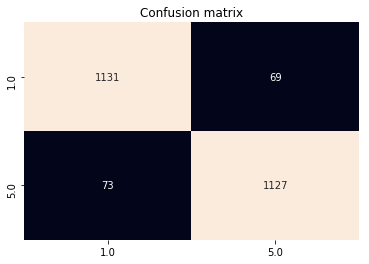

In [170]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))



labels = grid_tf_idf.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [100]:
tf_idf_model=pd.DataFrame.from_dict(grid_tf_idf.cv_results_)

In [223]:
tf_idf_model[['param_clf__C','param_clf__penalty','param_tfidf__analyzer','param_tfidf__max_df','param_tfidf__ngram_range','param_tfidf__norm','param_tfidf__use_idf','mean_test_accuracy','mean_test_f1']].sort_values('mean_test_accuracy', ascending=False).head(5)

,param_clf__C,param_clf__penalty,param_tfidf__analyzer,param_tfidf__max_df,param_tfidf__ngram_range,param_tfidf__norm,param_tfidf__use_idf,mean_test_accuracy,mean_test_f1
960,1000,l2,word,1,"(1, 1)",l1,True,0.936250,0.936985
674,10,l2,word,1,"(1, 1)",l2,True,0.935893,0.936712
662,10,l2,word,0.75,"(1, 1)",l2,True,0.935714,0.936505
936,1000,l2,word,0.5,"(1, 1)",l1,True,0.935536,0.936188
650,10,l2,word,0.5,"(1, 1)",l2,True,0.935357,0.936157


#### Попробуем добавить сигнулярное разложение:

In [179]:

 clf_tf_idf_TruncatedSVD = Pipeline([
    
    
   ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
   
    ('tsvd', TruncatedSVD()),
   
   ('clf', LogisticRegression()),
])


In [200]:




params_tf_idf_TruncatedSVD={
    
    'vect__analyzer':  ['word'],
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'tsvd__n_components' : [5,10,25,50,100],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]

  
}



scores=[ 'accuracy','f1']
grid_tf_idf_TruncatedSVD = GridSearchCV(clf_tf_idf_TruncatedSVD, param_grid=params_tf_idf_TruncatedSVD, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)
print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 26.6min finished


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])
Best score: 0.930


Precision:   0.92
Recall:   0.92
F1-measure:   0.92
Accuracy:   0.92
              precision    recall  f1-score   support

         1.0       0.93      0.92      0.92      1200
         5.0       0.92      0.93      0.92      1200

   micro avg       0.92      0.92      0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



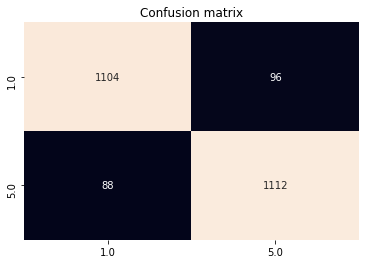

In [201]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))



labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [203]:
tf_idf__TruncatedSVD_model=pd.DataFrame.from_dict(grid_tf_idf_TruncatedSVD.cv_results_)

In [226]:
tf_idf__TruncatedSVD_model[['param_clf__C','param_clf__penalty','param_tsvd__n_components','param_vect__analyzer','param_vect__ngram_range','mean_test_accuracy','mean_test_f1']].sort_values('mean_test_accuracy', ascending=False).head()

,param_clf__C,param_clf__penalty,param_tsvd__n_components,param_vect__analyzer,param_vect__ngram_range,mean_test_accuracy,mean_test_f1
207,1000,l2,100,word,"(1, 1)",0.930000,0.930131
177,100,l2,100,word,"(1, 1)",0.928393,0.928798
132,10,l1,100,word,"(1, 1)",0.927679,0.927881
162,100,l1,100,word,"(1, 1)",0.927321,0.927793
147,10,l2,100,word,"(1, 1)",0.925893,0.926426


#### 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

In [208]:
clf_tf_idf_LDA = Pipeline([
    
    
   ('vect', CountVectorizer()),
   
   
    ('lda', LatentDirichletAllocation()),
   
   ('clf', LogisticRegression()),
])


In [214]:

params_tf_idf_LDA={
    
    'vect__analyzer':  ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'lda__n_components' : [25,50,100],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]

  
}



scores=[ 'accuracy','f1']
grid_tf_idf_LDA = GridSearchCV(clf_tf_idf_LDA, param_grid=params_tf_idf_LDA, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf_LDA.fit(X_train, y_train)
print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 91.8min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed: 196.3min finished


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])
Best score: 0.709


#### LDA сильно ухудшил результаты

Precision:   0.60
Recall:   0.60
F1-measure:   0.60
Accuracy:   0.60
              precision    recall  f1-score   support

         1.0       0.59      0.67      0.62      1200
         5.0       0.61      0.52      0.57      1200

   micro avg       0.60      0.60      0.60      2400
   macro avg       0.60      0.60      0.60      2400
weighted avg       0.60      0.60      0.60      2400



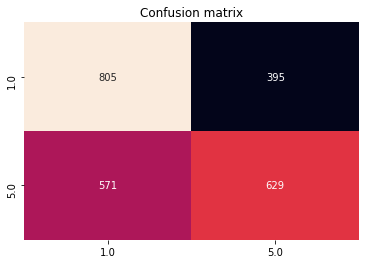

In [216]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))



labels = grid_tf_idf_LDA.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [215]:
LDA_model=pd.DataFrame.from_dict(grid_tf_idf_LDA.cv_results_)

In [221]:
LDA_model[['param_clf__C','param_clf__penalty','param_lda__n_components','param_vect__analyzer','param_vect__max_df','param_vect__ngram_range','mean_test_accuracy','mean_test_f1']].sort_values('mean_test_accuracy', ascending=False).head()

,param_clf__C,param_clf__penalty,param_lda__n_components,param_vect__analyzer,param_vect__max_df,param_vect__ngram_range,mean_test_accuracy,mean_test_f1
60,1,l1,100,word,0.75,"(1, 1)",0.708929,0.714358
87,10,l2,100,word,0.75,"(1, 1)",0.700714,0.706231
51,0.1,l2,100,word,0.75,"(1, 1)",0.657857,0.660057
102,100,l2,50,word,0.75,"(1, 1)",0.649821,0.675832
111,1000,l1,50,word,0.75,"(1, 1)",0.638036,0.683485


#### В качеттве саммари:

In [246]:
models=['grid_cntv', 'grid_tf_idf' ,'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']
for model in models:

    print('model: ',model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("F1-measure: {0:6.3f}".format(f1_score(y_test, predictions, average='macro')),';',"Accuracy: {0:6.3f}".format(accuracy_score(y_test, predictions)))
    print('_______________________________________________________')

model:  cntv
F1-measure:  0.935 ; Accuracy:  0.935
_______________________________________________________
model:  tf_idf
F1-measure:  0.941 ; Accuracy:  0.941
_______________________________________________________
model:  tf_idf_TruncatedSVD
F1-measure:  0.923 ; Accuracy:  0.923
_______________________________________________________
model:  tf_idf_LDA
F1-measure:  0.595 ; Accuracy:  0.598
_______________________________________________________


#### Как видим TF-IDF лучший результат показыват